In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from PIL import Image
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model



In [2]:
root_dir ='./'
base_dir = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/'
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"
if os.path.exists(work_dir):
    remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))    


Working Directory Contents: ['MildDemented', 'NonDemented', 'ModerateDemented', 'VeryMildDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
ZOOM_RANGE = [0.99,1.01]
BRIGHT_RANGE = [0.8,1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
work_dr = IDG(rescale=1./255, brightness_range = BRIGHT_RANGE, zoom_range = ZOOM_RANGE, data_format = DATA_FORMAT,
            fill_mode = FILL_MODE, horizontal_flip = HORZ_FLIP)

In [5]:
train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [6]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [7]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


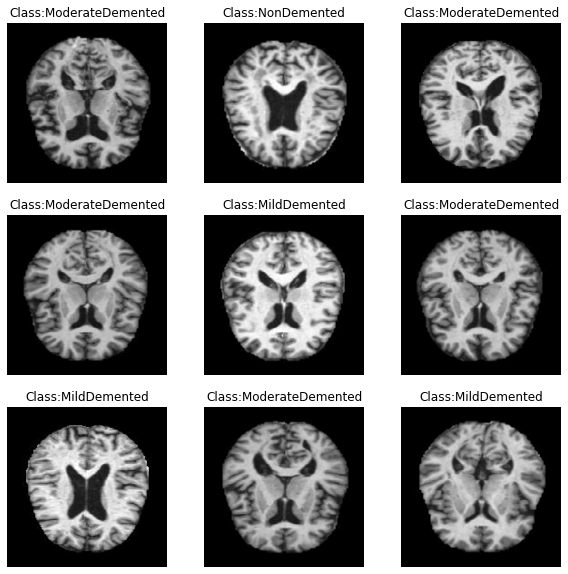

In [36]:
def show_images(generator, y_pred=None):
    labels = dict(zip([0,1,2,3], CLASSES))
    x,y = generator.next()
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3,3,i+1)
            idx = randint(0,6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
show_images(train_data_gen)
        
        


In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [9]:
from tensorflow.keras.applications import DenseNet121
DenseNet121_model = DenseNet121(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [10]:
for layer in DenseNet121_model.layers:
    layer.trainable=False

In [11]:

from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D

In [15]:
custom_DenseNet121_model=Sequential()
custom_DenseNet121_model.add(DenseNet121_model)
custom_DenseNet121_model.add(Dropout(0.5))
custom_DenseNet121_model.add(Flatten())
custom_DenseNet121_model.add(BatchNormalization())
custom_DenseNet121_model.add(Dense(1024))
custom_DenseNet121_model.add(BatchNormalization())
custom_DenseNet121_model.add(Activation('relu'))
custom_DenseNet121_model.add(Dropout(0.5))
custom_DenseNet121_model.add(Dense(1024))
custom_DenseNet121_model.add(BatchNormalization())
custom_DenseNet121_model.add(Activation('relu'))
custom_DenseNet121_model.add(Dropout(0.5))
custom_DenseNet121_model.add(Dense(4,activation='softmax'))


In [16]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True      
my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [17]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_DenseNet121_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_DenseNet121_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 5, 5, 1024)        7037504   
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 25600)             102400    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              26215424  
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_2 (Activation)    (None, 1024)             

In [18]:
EPOCHS = 100
history = custom_DenseNet121_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), 
                                 callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 28s 69ms/step - loss: 1.1412 - acc: 0.5960 - auc: 0.8343 - f1_score: 0.5945 - val_loss: 0.6832 - val_acc: 0.7554 - val_auc: 0.9358 - val_f1_score: 0.7374
Epoch 2/100
256/256 [==============================] - 15s 60ms/step - loss: 0.5820 - acc: 0.7660 - auc: 0.9439 - f1_score: 0.7645 - val_loss: 0.4730 - val_acc: 0.8091 - val_auc: 0.9617 - val_f1_score: 0.8001
Epoch 3/100
256/256 [==============================] - 15s 59ms/step - loss: 0.4381 - acc: 0.8234 - auc: 0.9660 - f1_score: 0.8213 - val_loss: 0.2959 - val_acc: 0.8911 - val_auc: 0.9834 - val_f1_score: 0.8901
Epoch 4/100
256/256 [==============================] - 15s 59ms/step - loss: 0.4006 - acc: 0.8446 - auc: 0.9711 - f1_score: 0.8437 - val_loss: 0.3468 - val_acc: 0.8755 - val_auc: 0.9782 - val_f1_score: 0.8727
Epoch 5/100
256/256 [==============================] - 15s 59ms/step - loss: 0.3398 - acc: 0.8703 - auc: 0.9794 - f1_score: 0.8713 - val_loss: 0.2722 - val_acc: 0.9

In [20]:
test_scores = custom_DenseNet121_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 3s 43ms/step - loss: 0.1896 - acc: 0.9379 - auc: 0.9920 - f1_score: 0.9376
Testing Accuracy: 93.79%


In [22]:
pred_lab = custom_DenseNet121_model.predict(test_data)

In [23]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_lab:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_lab, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.95      0.99      0.97       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.91      0.89      0.90       662
ModerateDemented       0.89      0.88      0.88       624

       micro avg       0.94      0.94      0.94      2560
       macro avg       0.94      0.94      0.94      2560
    weighted avg       0.94      0.94      0.94      2560
     samples avg       0.94      0.94      0.94      2560



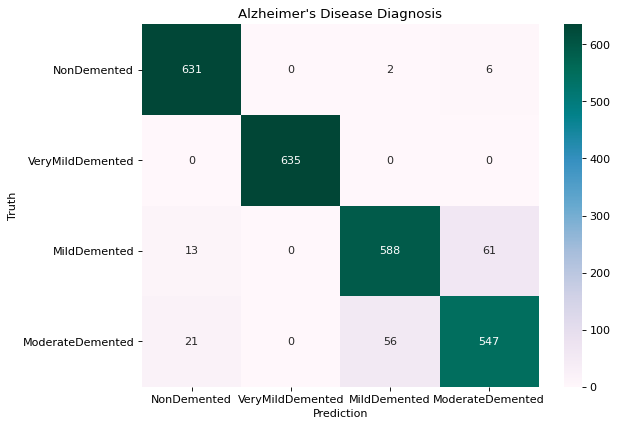

<Figure size 432x288 with 0 Axes>

In [25]:
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='PuBuGn', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
plt.savefig(work_dir+'custom_DenseNet121_model_confusion_final.png')



In [26]:
custom_DenseNet121_model_dir = work_dir + "custom_DenseNet121_cnn_model"
custom_DenseNet121_model.save(custom_DenseNet121_model_dir, save_format='h5')
os.listdir(work_dir)

['MildDemented',
 'NonDemented',
 'custom_DenseNet121_model_confusion_final.png',
 'ModerateDemented',
 'custom_DenseNet121_cnn_model',
 'VeryMildDemented']

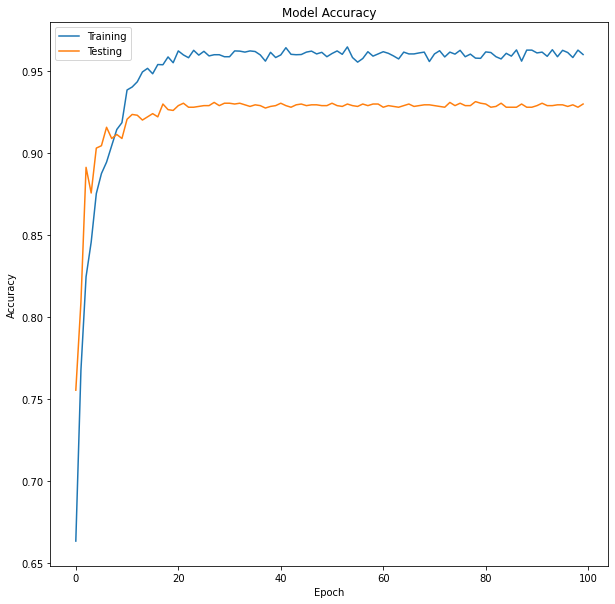

In [27]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig(work_dir+'custom_DenseNet121_accuracy_final.png')
plt.show()

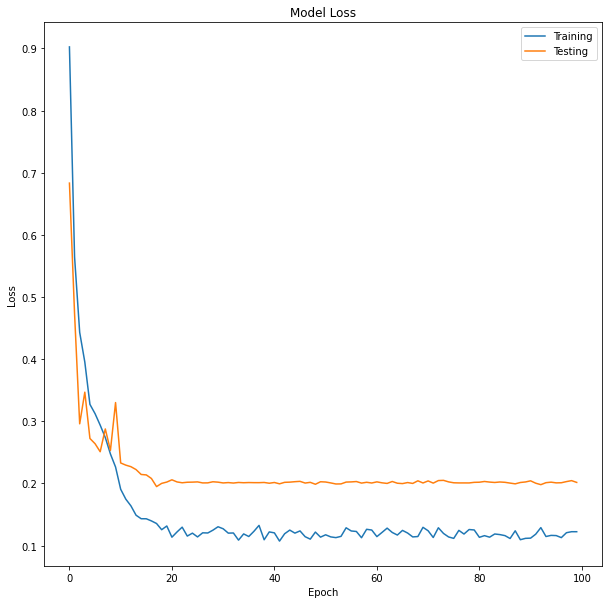

In [28]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
 
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig(work_dir+'custom_DenseNet121_loss_final.png')
plt.show()

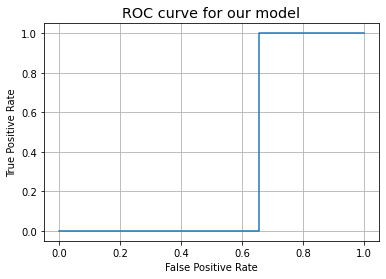

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)
fpr, tpr, thresholds = roc_curve(test_ls, pred_ls,pos_label=True)
# auc = roc_auc_score(test_ls, pred_ls)
# print('AUC: %.3f' % auc)
plt.plot(fpr, tpr)
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig(work_dir+'custom_DenseNet121_ROC_final.png')
plt.grid(True)


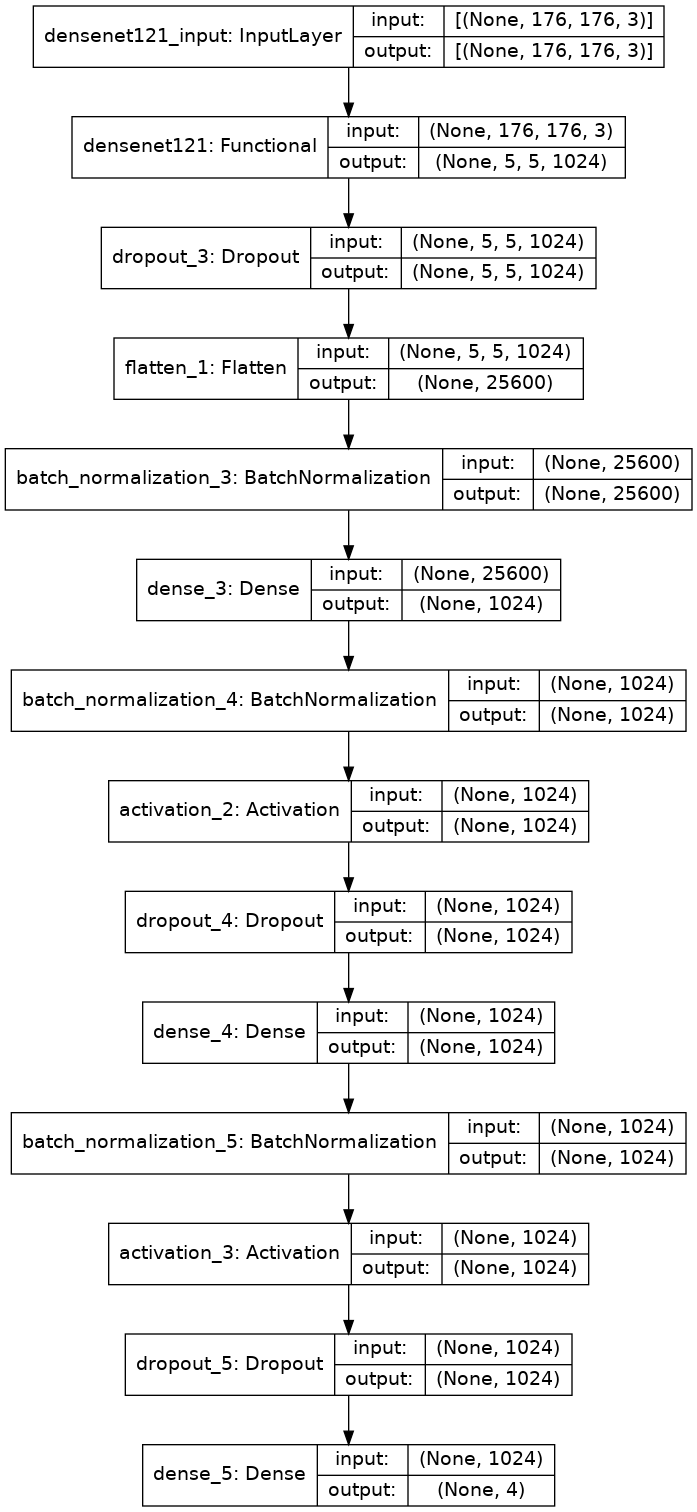

In [31]:
pretrained_model = custom_DenseNet121_model
plot_model(pretrained_model, to_file=work_dir + "custom_DenseNet121_architecture_plot.png", show_shapes=True, show_layer_names=True)
